In [1]:
import sys
sys.path.append("../..")

import numpy as np
from matplotlib import pyplot as plt
from scipy import stats as ss

from transfernode import node
from transfernode import line
from stochastic import stochastic
from genetics import ga
import tools

In [2]:
avtovokzal = node.Node()
# start times counting from 5AM: [75, 90, 30, 95, 0]
# start times counting from 6:30AM: [20, 0, 0, 5, 14]
line1 = line.Line(75, 15 + 20, stochastic.Stochastic(1, 3, 0.5), 0.35, "#1")
line2 = line.Line(90, 30, stochastic.Stochastic(1, 4, 1), 0.20, "#2")
line3 = line.Line(30, 20, stochastic.Stochastic(1, 5, 1), 0.25, "#3")
line4 = line.Line(95, 28, stochastic.Stochastic(1, 4, 0.5), 0.10, "#4")
line5 = line.Line(0, 26, stochastic.Stochastic(1, 4, 0.5), 0.10, "#5")

avtovokzal.origin_pass_number = 12  # [pas./h]
avtovokzal.lines = [line1, line2, line3, line4, line5]

In [3]:
nd, dur, N = avtovokzal, 180, 300

def fitness_function(shifts):
    for idx in range(len(nd.lines)):
        nd.lines[idx].shift = shifts[idx]
    res = []
    for _ in range(N):
        x = nd.simulate(duration=dur)
        res.append(x[0] / x[1])
    return np.array(res)

# res = fitness_function([20, 0, 0, 5, 14])
# res = fitness_function([75, 90, 30, 95, 0])

## Run GA

In [4]:
N = 100

winners = []
for pc in range(1, 11):
    print(pc)
    g = ga.GA()
    g.chromosome_size = len(avtovokzal.lines), 7
    g.population_size = 100
    g.generations = 10
    g.crossover_probability = 0.1 * pc
    g.mutation_probability = 0.2
    g.mutation_turns = 3
    g.fitness_function = lambda xs: fitness_function(xs).mean()
    winner = g.run()
    winners.append(winner[1])
    print()

1
winner #1 ([28, 32, 44, 27, 64], (14.583682738040034, <genetics.chromosome.Chromosome object at 0x12f98fb80>))
winner #2 ([32, 15, 31, 51, 18], (13.997271283542384, <genetics.chromosome.Chromosome object at 0x12f9b3d90>))
winner #3 ([32, 15, 31, 35, 18], (13.26007919964102, <genetics.chromosome.Chromosome object at 0x12f98e6b0>))
winner #4 ([32, 15, 31, 35, 18], (13.255526775418382, <genetics.chromosome.Chromosome object at 0x12f98e6b0>))
winner #5 ([32, 15, 31, 35, 18], (13.136648756561431, <genetics.chromosome.Chromosome object at 0x12f9b2350>))
winner #6 ([32, 15, 31, 35, 18], (13.105734424107021, <genetics.chromosome.Chromosome object at 0x12f98dea0>))
winner #7 ([32, 15, 31, 34, 18], (12.954003148697513, <genetics.chromosome.Chromosome object at 0x12f9b12a0>))
winner #8 ([32, 15, 29, 3, 18], (12.950777518606788, <genetics.chromosome.Chromosome object at 0x12f9cc340>))
winner #9 ([32, 15, 31, 33, 22], (13.006351717719543, <genetics.chromosome.Chromosome object at 0x12f98f220>))
w

In [5]:
np.array(winners).tofile('node_results/node_pc_10x10.txt', sep=',', format='%s')

## Analyze results

In [6]:
xs = np.fromfile('node_results/node_pc_10x10.txt', sep=',').reshape((10, 10))

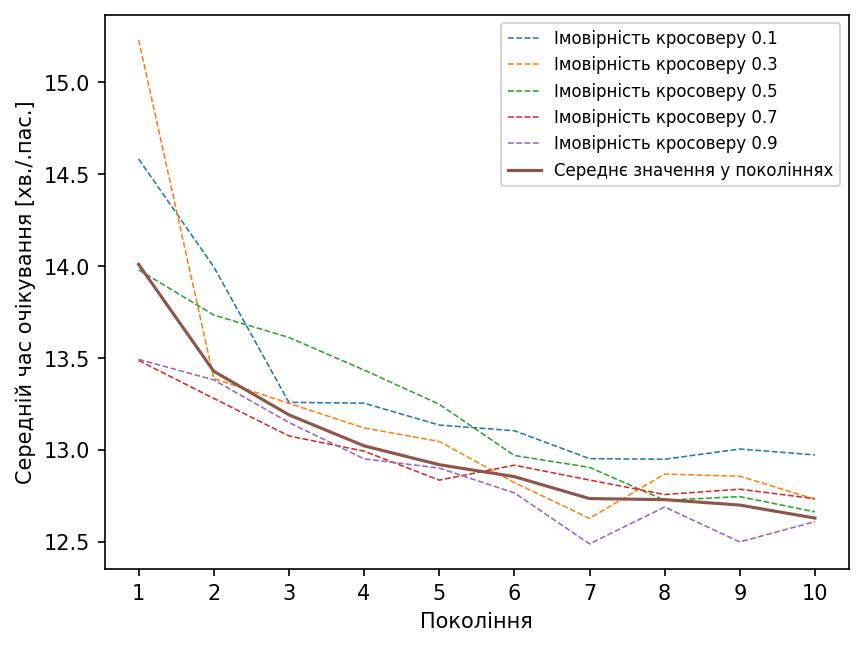

In [8]:
plt.figure(dpi=150)
xticks = range(1, 11, 1)
idx = 0
for pc in range(1, 11, 2):
    plt.plot(xticks, xs[idx], lw=0.75, linestyle='--',
             label=f'Імовірність кросоверу {round(0.1 * pc, 1)}')
    idx += 1
plt.plot(xticks, xs.mean(axis=0), lw=1.5, label=f'Середнє значення у поколіннях')
plt.ylabel('Середній час очікування [хв./.пас.]')
plt.xlabel('Покоління')
plt.xticks(xticks)
plt.legend(fontsize=8)
plt.show()

intercept=12.825095946616026
coefs=[-0.41452058]
R2=0.527301543895116
t_alfa(0.001,8)=5.0413054333884535
coef1	True	-0.738340304984949	-0.09070085961471164
intercept=14.490319592602516
coefs=[-0.87238911]
R2=0.20433418784507573
t_alfa(0.001,8)=5.0413054333884535
coef1	False	-2.2927532370211336	0.5479750119246852
intercept=13.248205872916365
coefs=[-0.40902724]
R2=0.4979515113406022
t_alfa(0.001,8)=5.0413054333884535
coef1	True	-0.7478918179509045	-0.0701626713790372


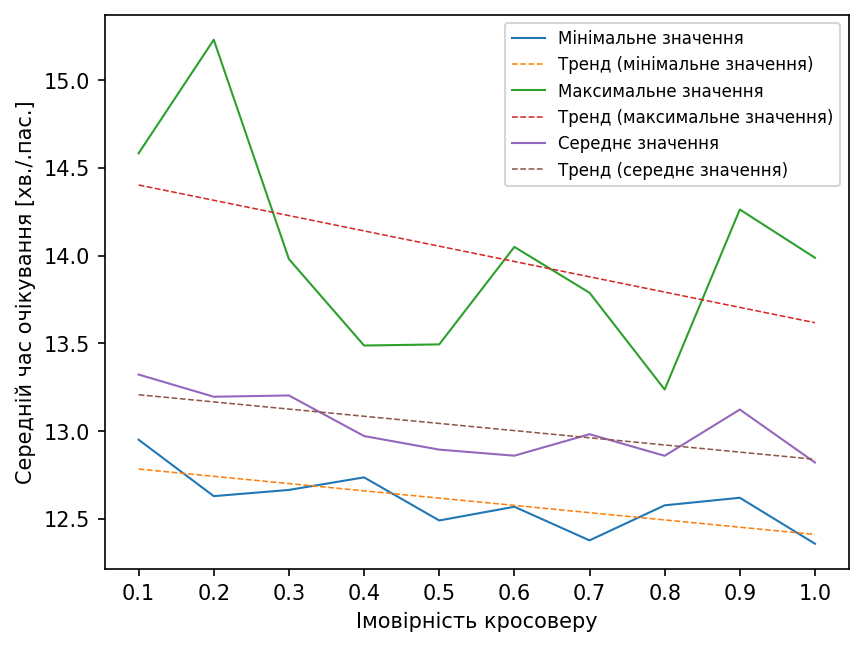

In [10]:
xticks = [0.1 * x for x in range(1, 11, 1)]
linear = lambda a, b, x: a + b * x

X = np.array([[x for x in xticks]]).T
rm_min = tools.make_regression(X, xs.min(axis=1), alpha=0.001, verbose=True)[0]
rm_max = tools.make_regression(X, xs.max(axis=1), alpha=0.001, verbose=True)[0]
rm_mean = tools.make_regression(X, xs.mean(axis=1), alpha=0.001, verbose=True)[0]

plt.figure(dpi=150)

plt.plot(xticks, xs.min(axis=1),lw=1, label='Мінімальне значення', linestyle='-')
plt.plot(xticks, linear(rm_min.intercept_, rm_min.coef_, xticks),
         lw=0.75, label='Тренд (мінімальне значення)', linestyle='--')

plt.plot(xticks, xs.max(axis=1),lw=1, label='Максимальне значення', linestyle='-')
plt.plot(xticks, linear(rm_max.intercept_, rm_max.coef_, xticks),
         lw=0.75, label='Тренд (максимальне значення)', linestyle='--')

plt.plot(xticks, xs.mean(axis=1),lw=1, label='Середнє значення', linestyle='-')
plt.plot(xticks, linear(rm_mean.intercept_, rm_mean.coef_, xticks),
         lw=0.75, label='Тренд (середнє значення)', linestyle='--')

plt.ylabel('Середній час очікування [хв./.пас.]')
plt.xlabel('Імовірність кросоверу')
plt.xticks(xticks)
plt.legend(fontsize=8, loc='upper right')
plt.show()